Geometry: NDBR50, Epoch [100/1000], Loss: 123933.6484
Geometry: NDBR50, Epoch [200/1000], Loss: 123222.8125
Geometry: NDBR50, Epoch [300/1000], Loss: 122161.5547
Geometry: NDBR50, Epoch [400/1000], Loss: 119335.0391
Geometry: NDBR50, Epoch [500/1000], Loss: 113105.5625
Geometry: NDBR50, Epoch [600/1000], Loss: 100116.4688
Geometry: NDBR50, Epoch [700/1000], Loss: 76800.5312
Geometry: NDBR50, Epoch [800/1000], Loss: 51911.8555
Geometry: NDBR50, Epoch [900/1000], Loss: 31684.2363
Geometry: NDBR50, Epoch [1000/1000], Loss: 18267.0078
Geometry: NDBR20, Epoch [100/1000], Loss: 12603.7305
Geometry: NDBR20, Epoch [200/1000], Loss: 8860.8760
Geometry: NDBR20, Epoch [300/1000], Loss: 7607.5977
Geometry: NDBR20, Epoch [400/1000], Loss: 6993.1709
Geometry: NDBR20, Epoch [500/1000], Loss: 6558.2207
Geometry: NDBR20, Epoch [600/1000], Loss: 6164.3501
Geometry: NDBR20, Epoch [700/1000], Loss: 5759.0645
Geometry: NDBR20, Epoch [800/1000], Loss: 5391.7588
Geometry: NDBR20, Epoch [900/1000], Loss: 5029

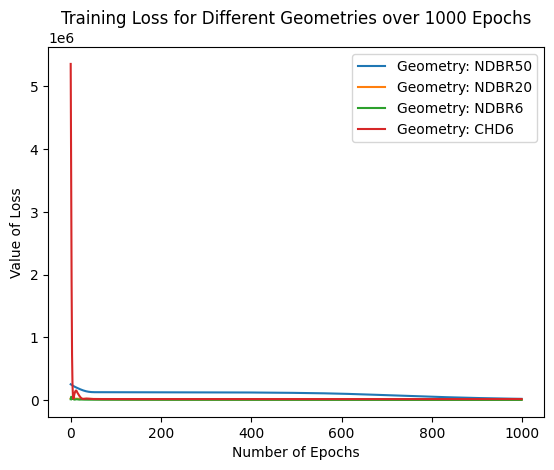

Predicted parameters for geometry NDBR50:
[0.10575037449598312, 245.15162658691406, 0.2868809401988983, 0.4036753177642822, 1050.0147705078125, 28.74175453186035, 404.03173828125]
Predicted parameters for geometry NDBR20:
[0.5506165623664856, 230.98654174804688, 0.1126251071691513, -0.06729866564273834, 994.2972412109375, 26.585037231445312, 381.0156555175781]
Predicted parameters for geometry NDBR6:
[0.2750599980354309, 246.04795837402344, 0.22162197530269623, 0.3861696720123291, 1055.30126953125, 28.634923934936523, 405.79302978515625]
Predicted parameters for geometry CHD6:
[0.2954257130622864, 246.0240936279297, 0.21300791203975677, 0.3796522617340088, 1055.381591796875, 28.608919143676758, 405.7823486328125]


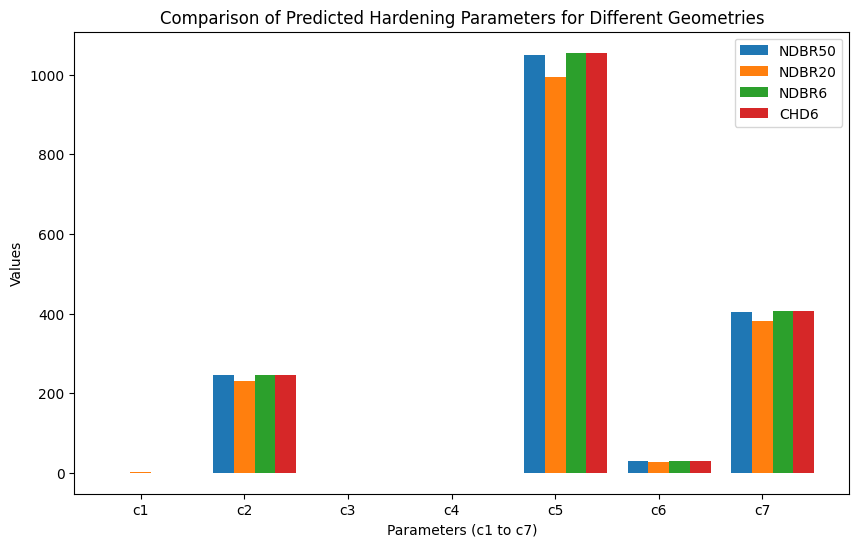

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define the geometries and yielding indices
geometries = ['NDBR50', 'NDBR20', 'NDBR6', 'CHD6']
yieldingIndices = {'NDBR50': 200, 'NDBR20': 200, 'NDBR6': 200, 'CHD6': 1200}

# Load data from CSV files
X_files = {
    'NDBR50': "MODEL_DATA/realFD_for_training/realFD_ndbr50.csv",
    'NDBR20': "MODEL_DATA/realFD_for_training/realFD_ndbr20.csv",
    'NDBR6': "MODEL_DATA/realFD_for_training/realFD_ndbr6.csv",
    'CHD6': "MODEL_DATA/realFD_for_training/realFD_chd6.csv"
}

Y_file = "MODEL_DATA/realFD_for_Training/expanded_realHardParam.csv"

X_data = {geometry: pd.read_csv(X_files[geometry], usecols=[0, 1]).values for geometry in geometries}
Y_data = pd.read_csv(Y_file).values

# Define a simple neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

input_size = 2  # Number of input parameters (force and displacement)
hidden_size1 = 64  # Number of units in the first hidden layer
hidden_size2 = 64  # Number of units in the second hidden layer
output_size = 7  # Number of output dimensions (c1 to c7)

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)

# Define a loss function (mean squared error) and an optimizer (e.g., Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000

# Lists to store loss values for each geometry
loss_lists = {geometry: [] for geometry in geometries}

for geometry in geometries:
    num_samples = yieldingIndices[geometry]
    X_sample = torch.tensor(X_data[geometry], dtype=torch.float32)[:num_samples]
    Y_sample = torch.tensor(Y_data, dtype=torch.float32)[:num_samples]

    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_sample)

        # Compute the loss
        loss = criterion(outputs, Y_sample)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_lists[geometry].append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Geometry: {geometry}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot the loss for each geometry in a single graph
for geometry in geometries:
    plt.plot(loss_lists[geometry], label=f'Geometry: {geometry}')

plt.xlabel('Number of Epochs')
plt.ylabel('Value of Loss')
plt.legend()
plt.title('Training Loss for Different Geometries over 1000 Epochs')
plt.show()

# Predict parameters for all geometries
predicted_parameters = {}

for geometry in geometries:
    X_test = torch.tensor(X_data[geometry][:1], dtype=torch.float32)
    with torch.no_grad():
        predictions = model(X_test)

    predicted_parameters[geometry] = predictions[0].tolist()

# Print predicted parameters for all geometries
for geometry, params in predicted_parameters.items():
    print(f'Predicted parameters for geometry {geometry}:')
    print(params)

# Visualize 'c1' to 'c7' values for each geometry in a single graph
param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
param_values = [predicted_parameters[geometry] for geometry in geometries]

plt.figure(figsize=(10, 6))
for i, geometry in enumerate(geometries):
    plt.bar(np.arange(len(param_names)) + i * 0.2, param_values[i], width=0.2, label=f'{geometry}')

plt.xlabel('Parameters (c1 to c7)')
plt.ylabel('Values')
plt.title('Comparison of Predicted Hardening Parameters for Different Geometries')
plt.xticks(np.arange(len(param_names)) + 0.2, param_names)
plt.legend()
plt.show()


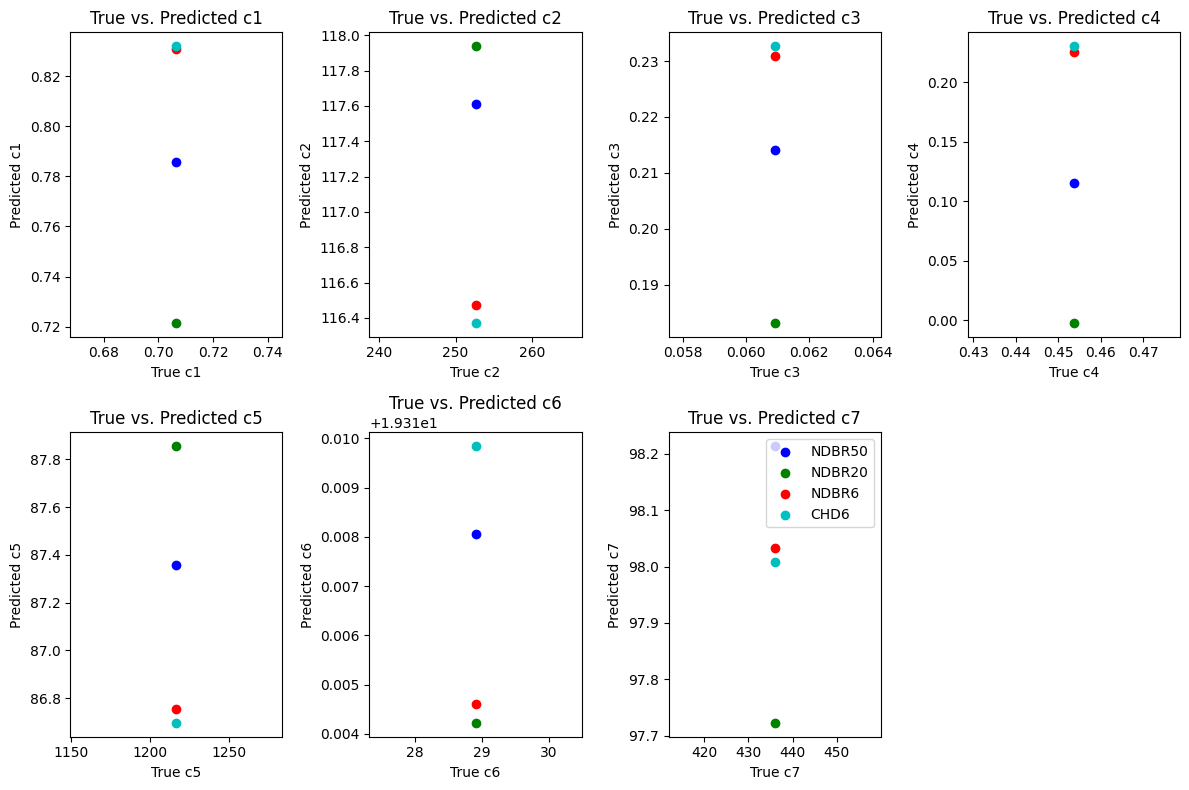

In [14]:
# Create scatterplots for true vs. predicted values for each parameter with labels and different colors
plt.figure(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c']  # You can define custom colors for each geometry

for i, param_name in enumerate(param_names):
    plt.subplot(2, 4, i + 1)
    for j, geometry in enumerate(geometries):
        true_values = true_vs_predicted_df[f'True_{param_name}']
        predicted_values = true_vs_predicted_df[f'Predicted_{param_name}']
        plt.scatter(true_values[j], predicted_values[j], label=geometry, c=colors[j])

    plt.xlabel(f'True {param_name}')
    plt.ylabel(f'Predicted {param_name}')
    plt.title(f'True vs. Predicted {param_name}')
    
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
# Print real vs. predicted values for all geometries
for geometry in geometries:
    print(f"Geometry: {geometry}")
    for param_name in param_names:
        true_values = true_vs_predicted_df[f'True_{param_name}'][true_vs_predicted_df['Geometry'] == geometry].values
        predicted_values = true_vs_predicted_df[f'Predicted_{param_name}'][true_vs_predicted_df['Geometry'] == geometry].values
        print(f"{param_name}:")
        for true, predicted in zip(true_values, predicted_values):
            print(f"  Real: {true:.4f}, Predicted: {predicted:.4f}")

    print()


Geometry: NDBR50
c1:
  Real: 0.7066, Predicted: 0.7857
c2:
  Real: 252.6253, Predicted: 117.6083
c3:
  Real: 0.0609, Predicted: 0.2141
c4:
  Real: 0.4536, Predicted: 0.1155
c5:
  Real: 1216.5217, Predicted: 87.3568
c6:
  Real: 28.9029, Predicted: 19.3181
c7:
  Real: 435.9436, Predicted: 98.2133

Geometry: NDBR20
c1:
  Real: 0.7066, Predicted: 0.7215
c2:
  Real: 252.6253, Predicted: 117.9382
c3:
  Real: 0.0609, Predicted: 0.1832
c4:
  Real: 0.4536, Predicted: -0.0023
c5:
  Real: 1216.5217, Predicted: 87.8549
c6:
  Real: 28.9029, Predicted: 19.3142
c7:
  Real: 435.9436, Predicted: 97.7227

Geometry: NDBR6
c1:
  Real: 0.7066, Predicted: 0.8308
c2:
  Real: 252.6253, Predicted: 116.4706
c3:
  Real: 0.0609, Predicted: 0.2309
c4:
  Real: 0.4536, Predicted: 0.2251
c5:
  Real: 1216.5217, Predicted: 86.7526
c6:
  Real: 28.9029, Predicted: 19.3146
c7:
  Real: 435.9436, Predicted: 98.0328

Geometry: CHD6
c1:
  Real: 0.7066, Predicted: 0.8319
c2:
  Real: 252.6253, Predicted: 116.3721
c3:
  Real: 0.

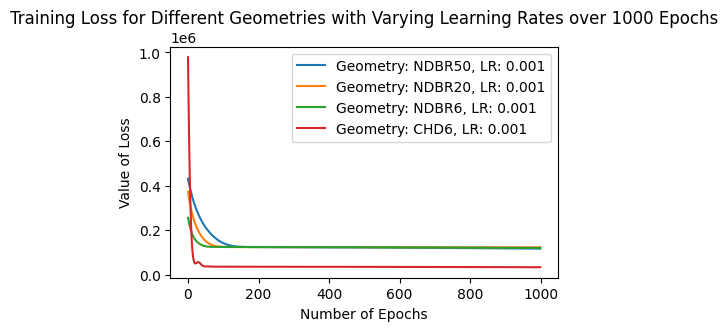

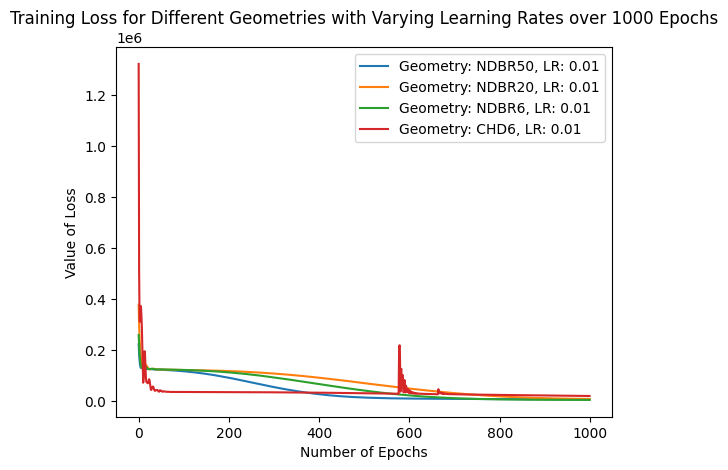

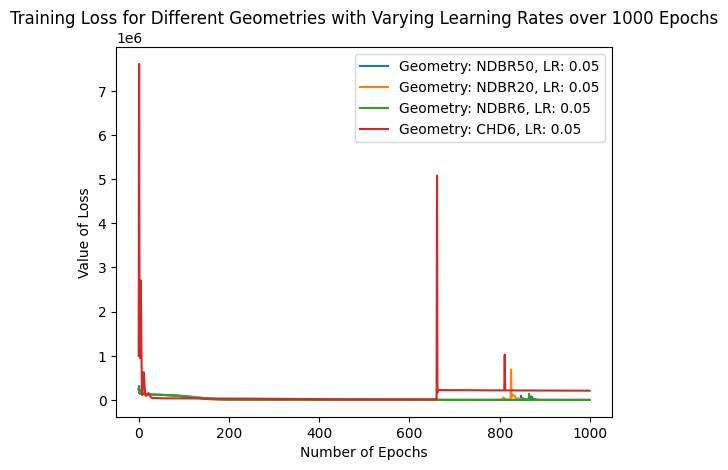

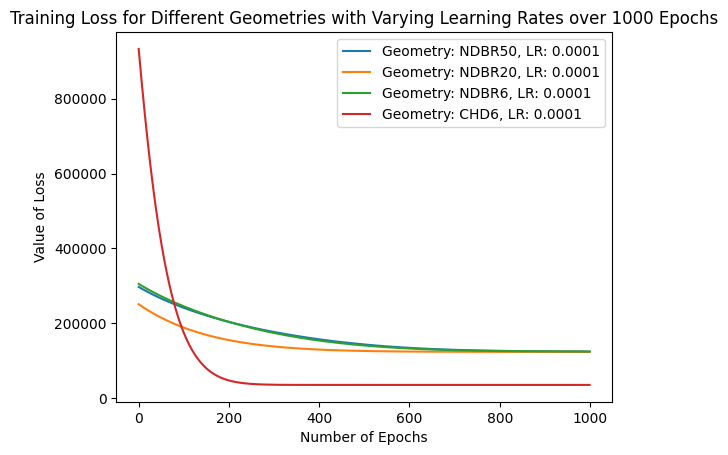

In [21]:
learning_rates = [0.001, 0.01, 0.05, 0.0001]
num_epochs = 1000

# Lists to store loss values for each geometry and learning rate
loss_lists = {geometry: {lr: [] for lr in learning_rates} for geometry in geometries}

for geometry in geometries:
    num_samples = yieldingIndices[geometry]
    X_sample = torch.tensor(X_data[geometry], dtype=torch.float32)[:num_samples]
    Y_sample = torch.tensor(Y_data, dtype=torch.float32)[:num_samples]

    for lr in learning_rates:
        model = NeuralNetwork(input_size, hidden_size, output_size)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for epoch in range(num_epochs):
            # Forward pass
            outputs = model(X_sample)

            # Compute the loss
            loss = criterion(outputs, Y_sample)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_lists[geometry][lr].append(loss.item())

# Plot the loss for each geometry and learning rate in separate graphs
plt.figure(figsize=(5, 3))
for lr in learning_rates:
    for geometry in geometries:
        plt.plot(loss_lists[geometry][lr], label=f'Geometry: {geometry}, LR: {lr}')

    plt.xlabel('Number of Epochs')
    plt.ylabel('Value of Loss')
    plt.legend()
    plt.title(f'Training Loss for Different Geometries with Varying Learning Rates over {num_epochs} Epochs')
    plt.show()
